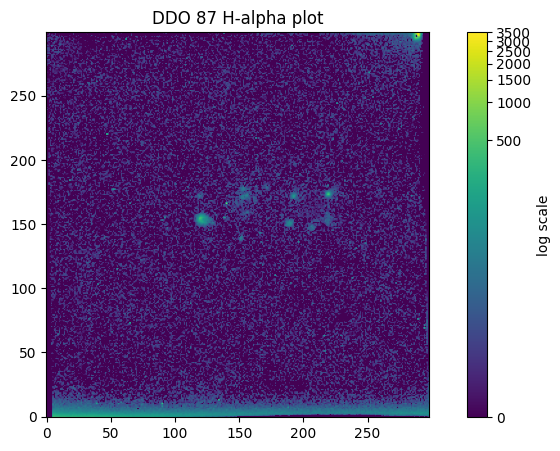

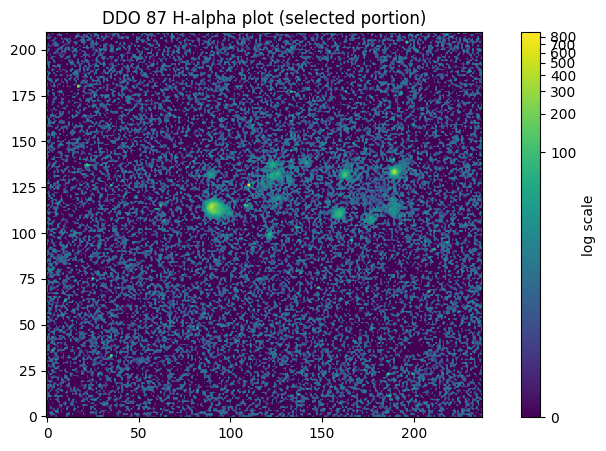

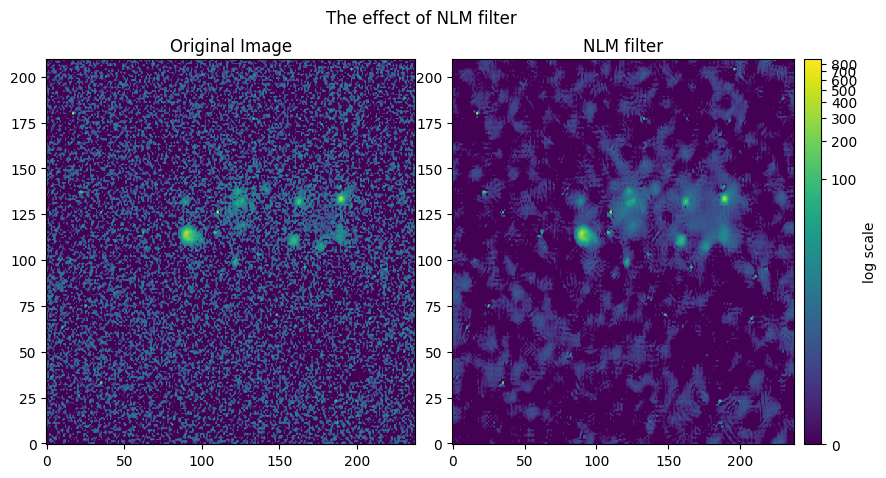

In [14]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
from astropy.io import fits
import os
import little_things_functions as ltf

# Load the image from a FITS file
def load_fits_image(file_path):
    with fits.open(file_path) as hdul:
        image_data = hdul[0].data

    # Handle byte order
    if image_data.dtype.byteorder == '>':
        image_data = image_data.byteswap().newbyteorder()

    # Handle NaNs and infinite values
    image_data = np.nan_to_num(image_data, nan=0.0, posinf=0.0, neginf=0.0)
    
    return image_data

# Specify the path to your FITS file
fits_file_path = r"C:\Users\AYSAN\Desktop\project\Galaxy\Code\d87\cropped_DDO 87_H.fits"  
# Load the image
image = load_fits_image(fits_file_path)
ltf.log_scale_plot(image, "DDO 87 H-alpha plot", "log scale")

image_section = image[40:250 , 30:-30]
ltf.log_scale_plot(image_section,"DDO 87 H-alpha plot (selected portion)", "log scale" )
from skimage.restoration import denoise_nl_means, estimate_sigma

# Apply Non-Local Means Filter
def apply_nl_means_filter(image):
    sigma_est = np.mean(estimate_sigma(image, channel_axis=None))
    nlm_filtered = denoise_nl_means(image, h=1.15 * sigma_est, fast_mode=True, patch_size=5, patch_distance=3, channel_axis=None)
    return nlm_filtered

nlm_filtered_image = apply_nl_means_filter(image_section)

# Display the result
ltf.log_scale_plot_2_images(image_section, nlm_filtered_image, "Original Image", "NLM filter", "The effect of NLM filter", "log scale", 0.1)


# STD of pixels above threshold

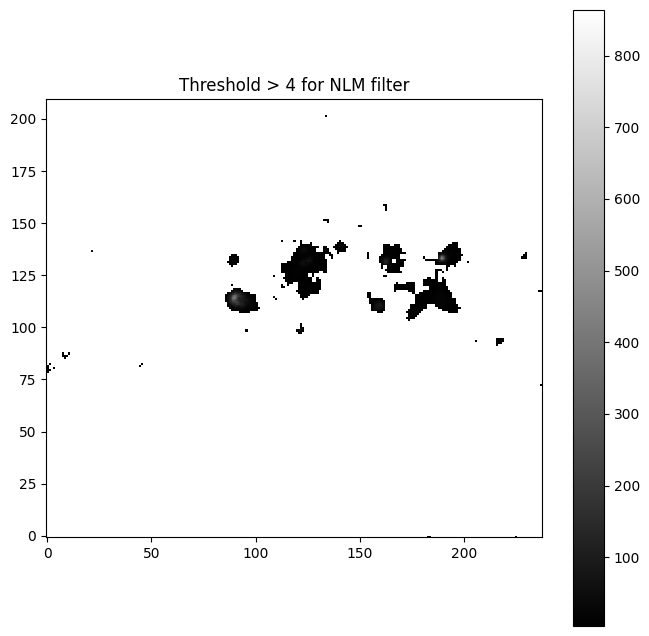

Sum of pixel values above threshold 4: 36774.93
Estimated error (standard deviation): ±36.60



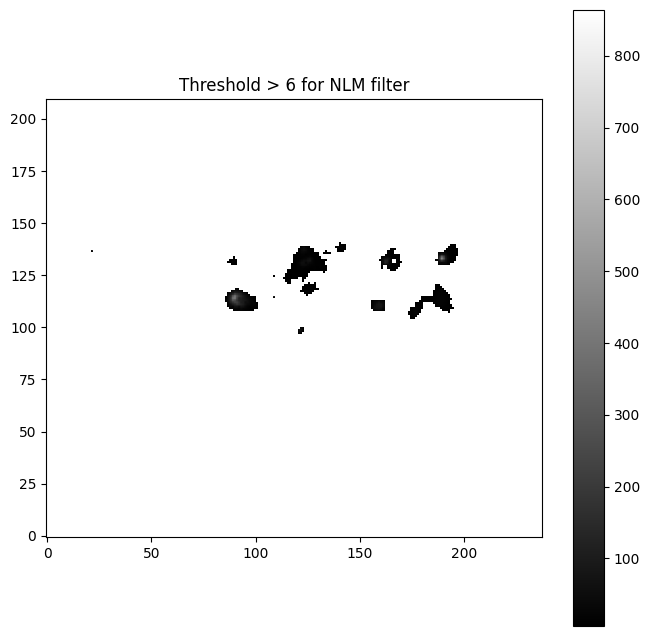

Sum of pixel values above threshold 6: 30759.82
Estimated error (standard deviation): ±49.89



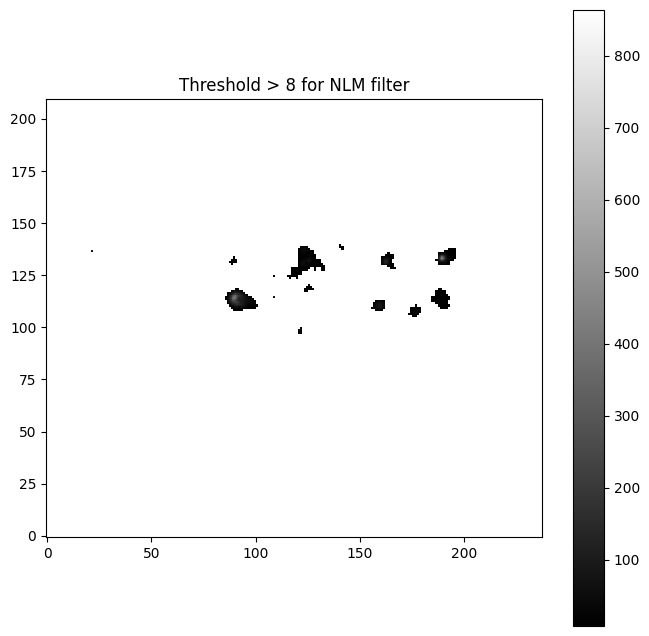

Sum of pixel values above threshold 8: 27799.82
Estimated error (standard deviation): ±59.46



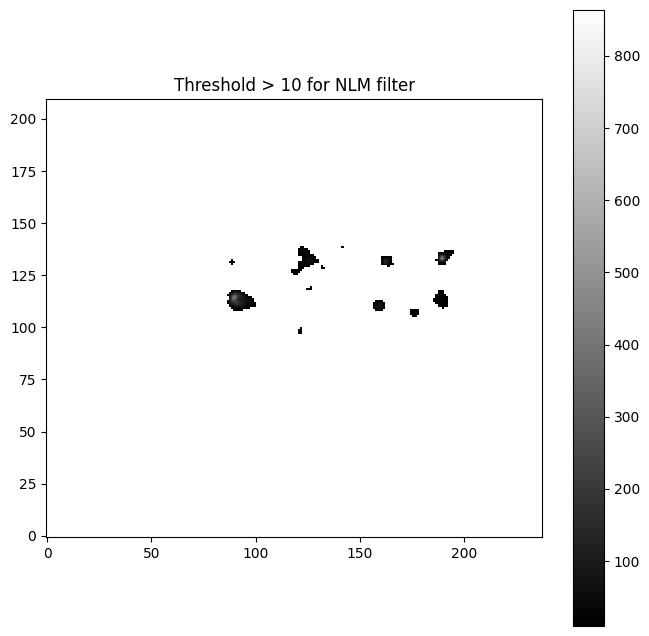

Sum of pixel values above threshold 10: 25776.35
Estimated error (standard deviation): ±67.38



In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Define thresholds
threshold_levels = [4, 6, 8, 10]

# Function to apply thresholds and calculate error
def apply_threshold_with_error(image, thresholds, filter_type):
    for threshold in thresholds:
        # Make a copy of the image and apply the threshold
        modified_image = np.copy(image)
        modified_image[modified_image <= threshold] = np.nan
        
        # Plot the modified image
        plt.figure(figsize=(8, 8))
        plt.imshow(modified_image, origin='lower', cmap='gray')
        plt.title(f'Threshold > {threshold} for {filter_type}')
        plt.colorbar()
        plt.show()
        
        # Calculate the sum of pixel values above the threshold
        sum_values = np.nansum(modified_image)
        # Calculate the standard deviation of pixel values above the threshold
        std_dev = np.nanstd(modified_image)
        
        # Print the results
        print(f"Sum of pixel values above threshold {threshold}: {sum_values:.2f}")
        print(f"Estimated error (standard deviation): ±{std_dev:.2f}\n")

# Example usage with your Non-Local Means filtered image
# Replace 'nlm_filtered_image' with your actual image array
apply_threshold_with_error(nlm_filtered_image, threshold_levels, "NLM filter")

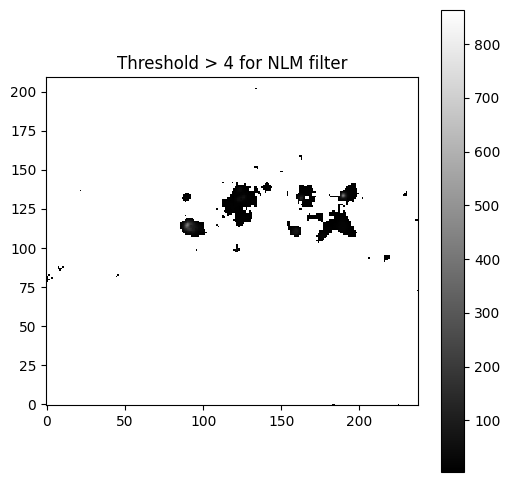

Threshold > 4 for NLM filter:
Integrated sum: 36774.93
Bootstrap error estimate (n=1000): ±1868.98



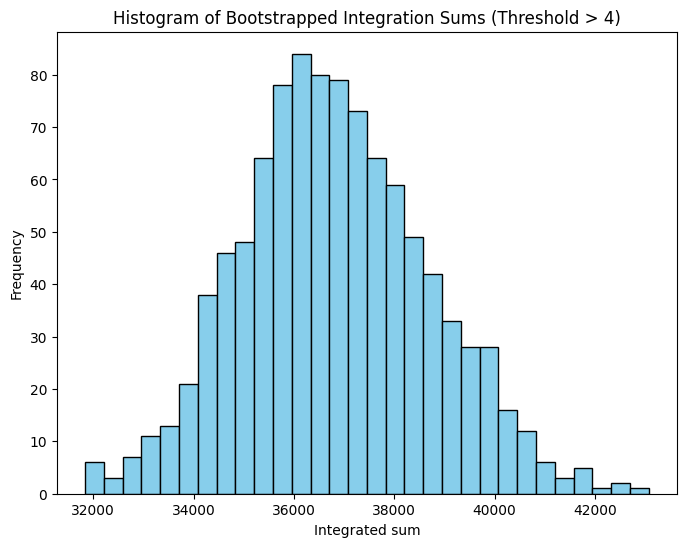

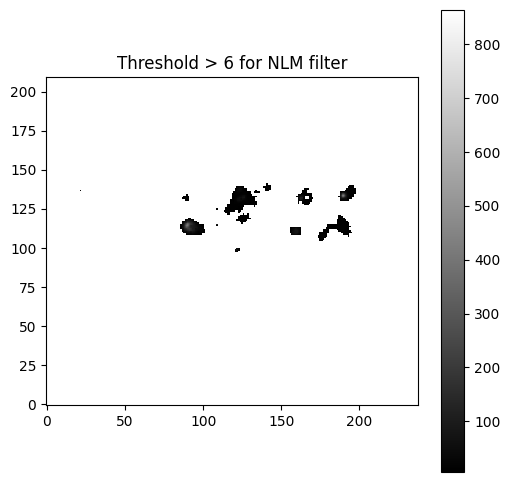

Threshold > 6 for NLM filter:
Integrated sum: 30759.82
Bootstrap error estimate (n=1000): ±1809.89



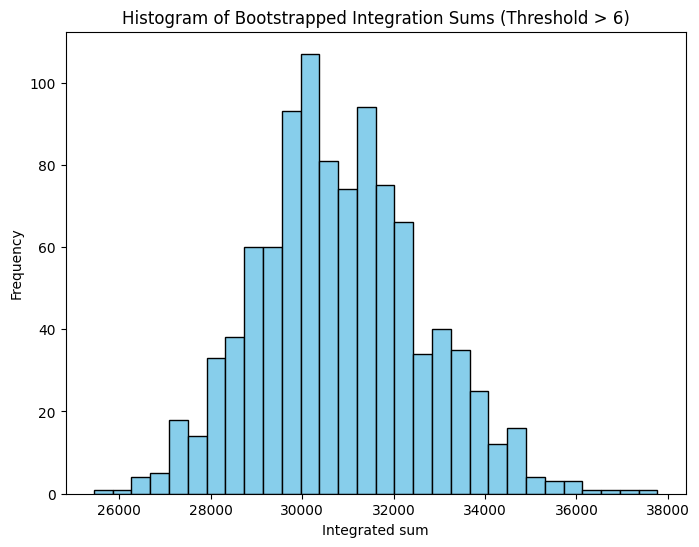

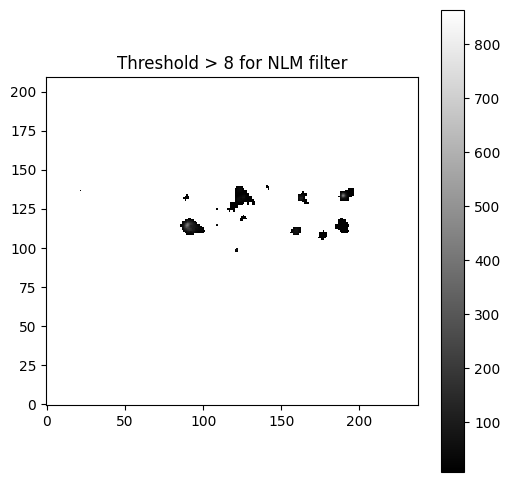

Threshold > 8 for NLM filter:
Integrated sum: 27799.82
Bootstrap error estimate (n=1000): ±1756.26



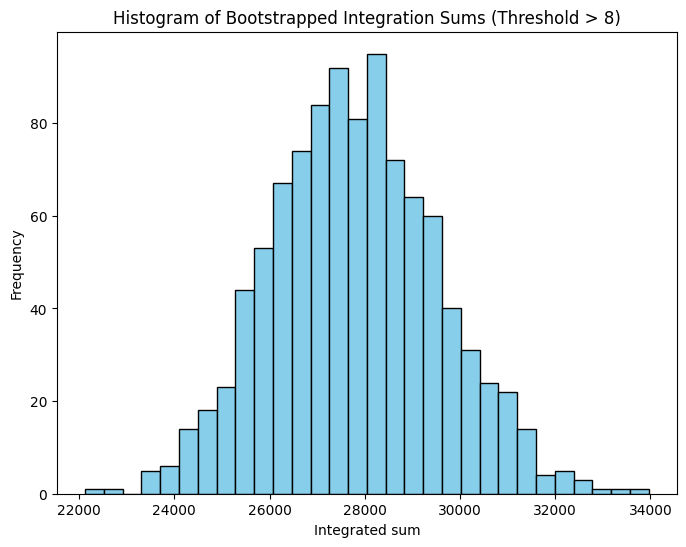

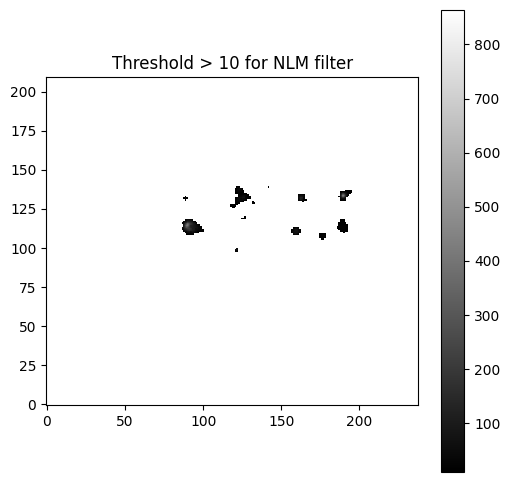

Threshold > 10 for NLM filter:
Integrated sum: 25776.35
Bootstrap error estimate (n=1000): ±1670.45



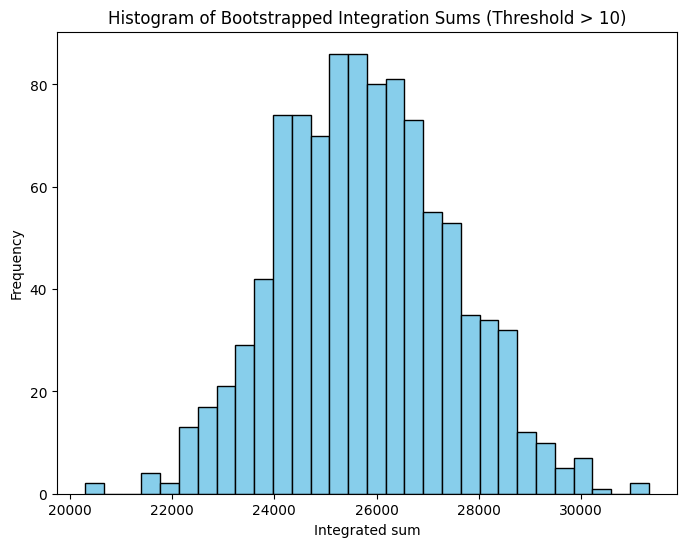

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def apply_threshold_with_bootstrap(image, thresholds, filter_type, n_bootstrap=1000):
    """
    For each threshold:
      - Masks pixels (sets to NaN) below or equal to the threshold.
      - Displays the modified image.
      - Computes the integrated sum of pixels above the threshold.
      - Estimates the error by resampling the valid pixels many times.
      - Plots a histogram of the integrated sums from bootstrap resampling.
    
    Parameters:
      image: 2D numpy array representing the image.
      thresholds: A list of threshold values.
      filter_type: A descriptive string for the filter used.
      n_bootstrap: The number of bootstrap iterations.
    """
    for threshold in thresholds:
        # Create a modified copy of the image and apply the threshold
        modified_image = np.copy(image)
        modified_image[modified_image <= threshold] = np.nan
        
        # Plot the thresholded image
        plt.figure(figsize=(6, 6))
        plt.imshow(modified_image, origin='lower', cmap='gray')
        plt.title(f'Threshold > {threshold} for {filter_type}')
        plt.colorbar()
        plt.show()
        
        # Extract valid pixels above the threshold (ignoring NaN values)
        mask = ~np.isnan(modified_image)
        valid_values = modified_image[mask]
        N = len(valid_values)
        
        # Compute the integrated sum of the valid pixels
        integrated_sum = np.nansum(modified_image)
        
        # Bootstrap: collect integrated sums from resampling
        bootstrap_sums = []
        for _ in range(n_bootstrap):
            # Sample with replacement from the valid pixel values
            sample = np.random.choice(valid_values, size=N, replace=True)
            bootstrap_sums.append(np.sum(sample))
        bootstrap_sums = np.array(bootstrap_sums)
        bootstrap_error = np.std(bootstrap_sums)
        
        # Output the results for the current threshold
        print(f"Threshold > {threshold} for {filter_type}:")
        print(f"Integrated sum: {integrated_sum:.2f}")
        print(f"Bootstrap error estimate (n={n_bootstrap}): ±{bootstrap_error:.2f}\n")
        
        # Plot a histogram of the bootstrapped integrated sums
        plt.figure(figsize=(8, 6))
        plt.hist(bootstrap_sums, bins=30, color='skyblue', edgecolor='black')
        plt.title(f'Histogram of Bootstrapped Integration Sums (Threshold > {threshold})')
        plt.xlabel('Integrated sum')
        plt.ylabel('Frequency')
        plt.show()

# Define the thresholds and apply the bootstrapping procedure
threshold_levels = [4, 6, 8, 10]
apply_threshold_with_bootstrap(nlm_filtered_image, threshold_levels, "NLM filter", n_bootstrap=1000)


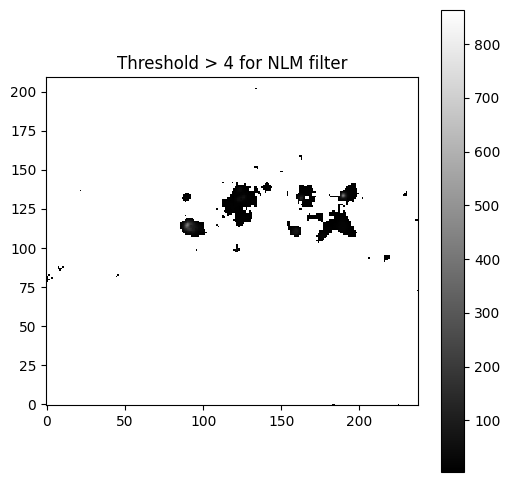

Threshold > 4 for NLM filter:
Integrated sum: 36774.93
Bootstrap error estimate: ±1856.78
Gaussian noise error estimate: ±50.81
Poisson noise error estimate: ±196.16



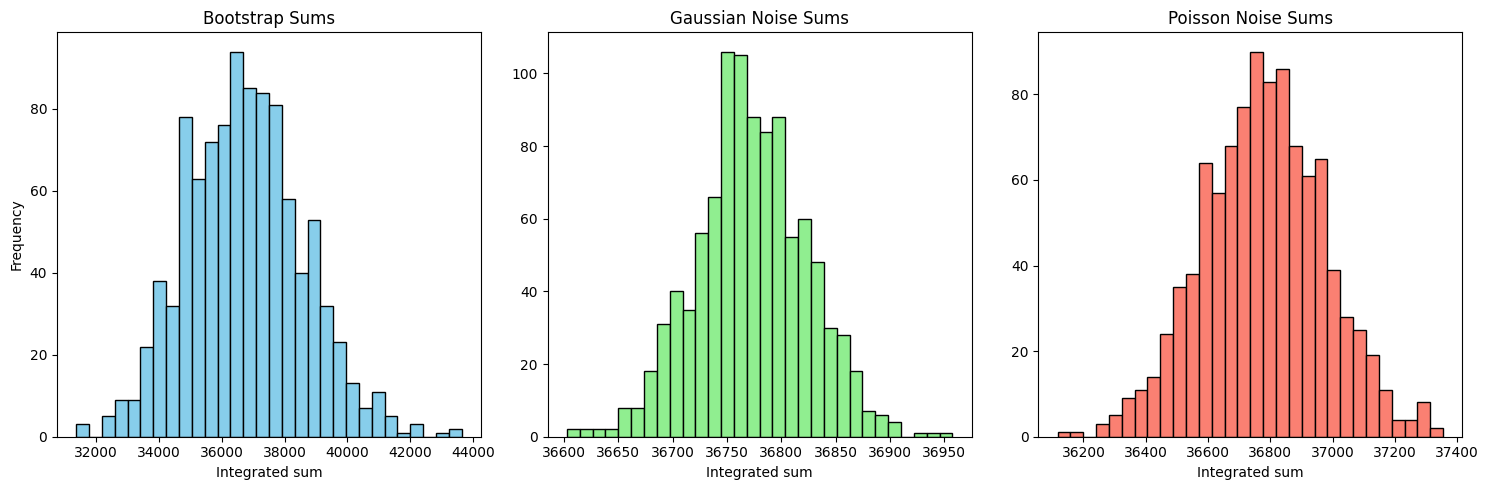

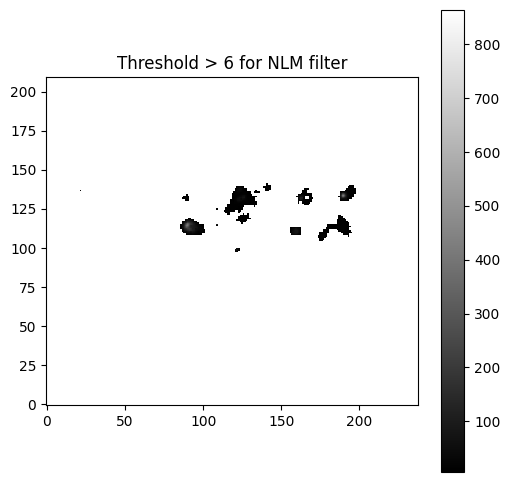

Threshold > 6 for NLM filter:
Integrated sum: 30759.82
Bootstrap error estimate: ±1788.53
Gaussian noise error estimate: ±35.11
Poisson noise error estimate: ±169.43



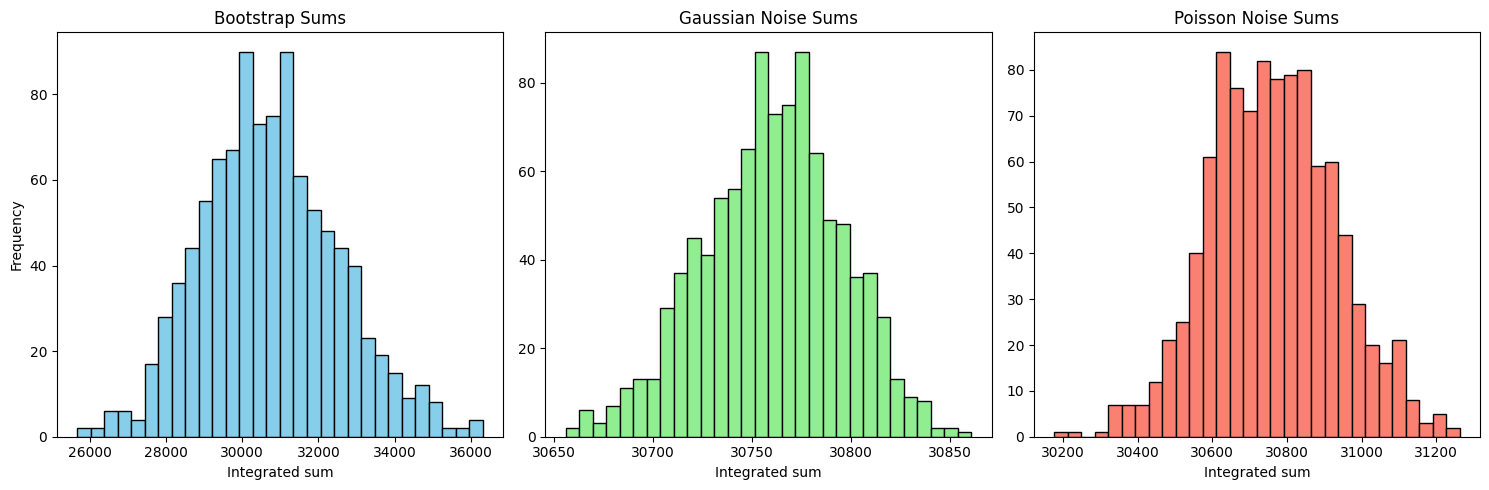

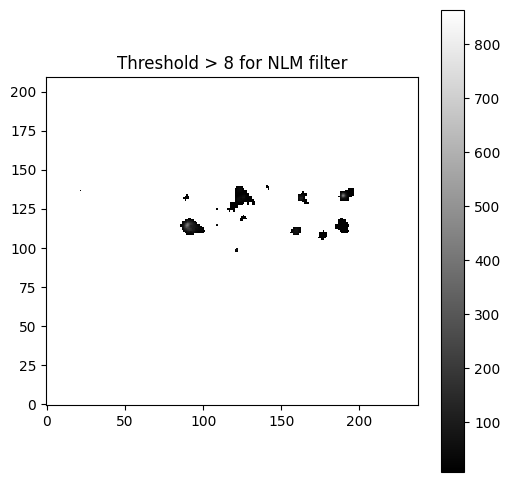

Threshold > 8 for NLM filter:
Integrated sum: 27799.82
Bootstrap error estimate: ±1771.71
Gaussian noise error estimate: ±28.83
Poisson noise error estimate: ±166.15



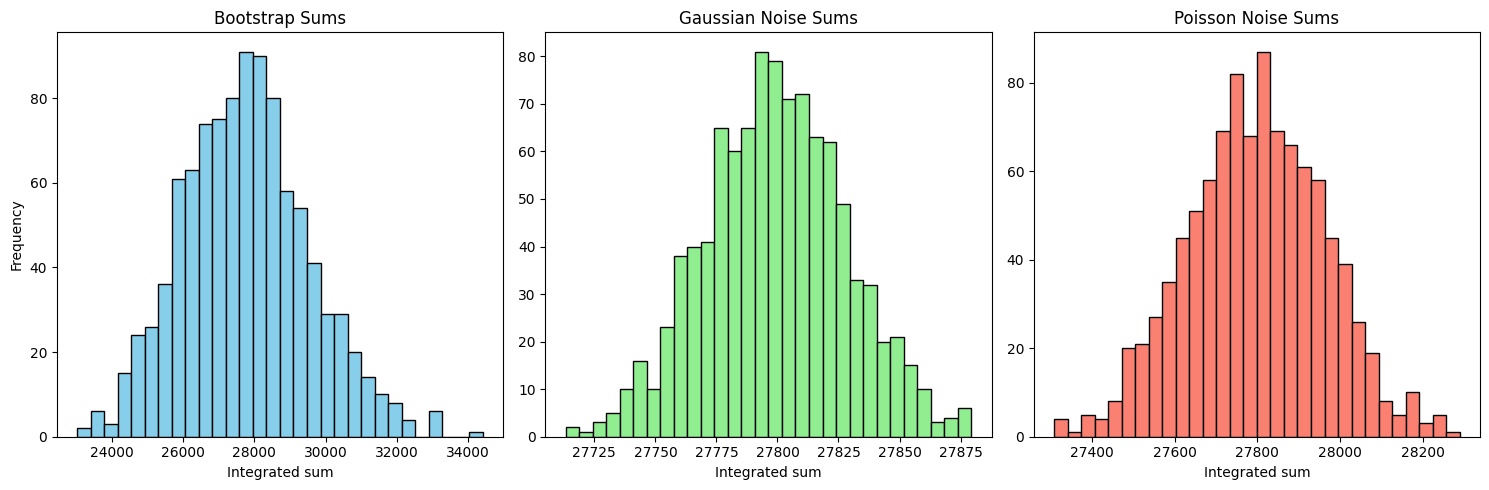

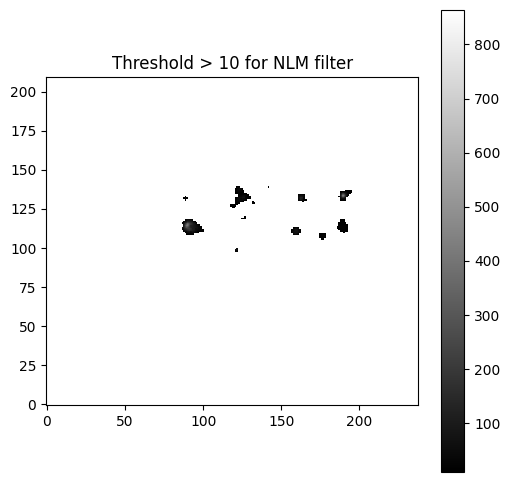

Threshold > 10 for NLM filter:
Integrated sum: 25776.35
Bootstrap error estimate: ±1627.06
Gaussian noise error estimate: ±24.39
Poisson noise error estimate: ±162.33



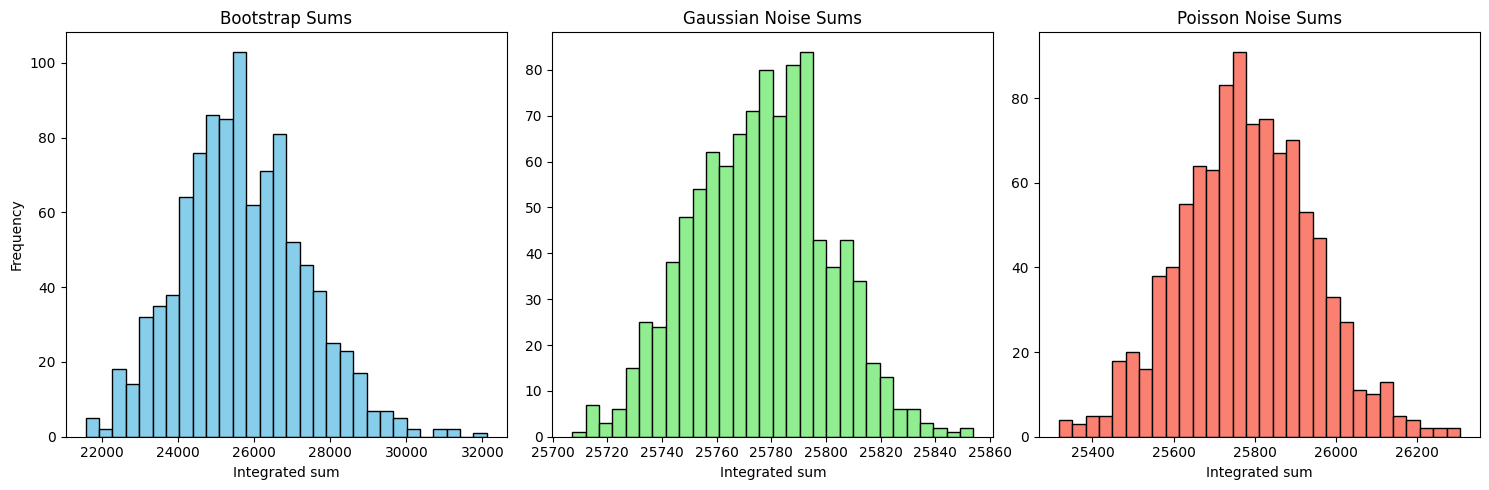

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Function to apply thresholds and calculate errors using three methods
def apply_threshold_with_error_methods(image, thresholds, filter_type, assumed_pixel_error=1.0, n_bootstrap=1000):
    """
    For each threshold, this function:
      - Masks pixels below or equal to the threshold,
      - Displays the modified image,
      - Computes the integrated sum,
      - Estimates the error using three methods:
        1. Bootstrapping with replacement
        2. Gaussian noise injection
        3. Poisson noise injection
      - Plots histograms of the integrated sums for each method.
    """
    for threshold in thresholds:
        # Copy and mask the image
        modified_image = np.copy(image)
        modified_image[modified_image <= threshold] = np.nan

        # Plot the modified image
        plt.figure(figsize=(6, 6))
        plt.imshow(modified_image, origin='lower', cmap='gray')
        plt.title(f'Threshold > {threshold} for {filter_type}')
        plt.colorbar()
        plt.show()

        # Extract valid pixel values (above threshold)
        mask = ~np.isnan(modified_image)
        valid_values = modified_image[mask]
        N = len(valid_values)

        # Compute integrated sum
        integrated_sum = np.nansum(modified_image)

        # Method 1: Bootstrapping with Replacement
        bootstrap_sums = []
        for _ in range(n_bootstrap):
            sample = np.random.choice(valid_values, size=N, replace=True)
            bootstrap_sums.append(np.sum(sample))
        bootstrap_error = np.std(bootstrap_sums)

        # Method 2: Gaussian Noise Injection
        gaussian_sums = []
        for _ in range(n_bootstrap):
            noisy_values = valid_values + np.random.normal(0, assumed_pixel_error, size=N)
            gaussian_sums.append(np.sum(noisy_values))
        gaussian_error = np.std(gaussian_sums)

        # Method 3: Poisson Noise Injection
        poisson_sums = []
        for _ in range(n_bootstrap):
            noisy_values = np.random.poisson(lam=np.clip(valid_values, 0.1, None))  # Poisson requires non-negative values
            poisson_sums.append(np.sum(noisy_values))
        poisson_error = np.std(poisson_sums)

        # Report the results
        print(f"Threshold > {threshold} for {filter_type}:")
        print(f"Integrated sum: {integrated_sum:.2f}")
        print(f"Bootstrap error estimate: ±{bootstrap_error:.2f}")
        print(f"Gaussian noise error estimate: ±{gaussian_error:.2f}")
        print(f"Poisson noise error estimate: ±{poisson_error:.2f}\n")

        # Plot histograms of the integrated sums for each method
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.hist(bootstrap_sums, bins=30, color='skyblue', edgecolor='black')
        plt.title('Bootstrap Sums')
        plt.xlabel('Integrated sum')
        plt.ylabel('Frequency')

        plt.subplot(1, 3, 2)
        plt.hist(gaussian_sums, bins=30, color='lightgreen', edgecolor='black')
        plt.title('Gaussian Noise Sums')
        plt.xlabel('Integrated sum')

        plt.subplot(1, 3, 3)
        plt.hist(poisson_sums, bins=30, color='salmon', edgecolor='black')
        plt.title('Poisson Noise Sums')
        plt.xlabel('Integrated sum')

        plt.tight_layout()
        plt.show()


threshold_levels = [4, 6, 8, 10]
apply_threshold_with_error_methods(nlm_filtered_image, threshold_levels, "NLM filter", assumed_pixel_error=1.0, n_bootstrap=1000)
